#MNIST-based Four-Digit Number Recognition Using CNN

Siddique Abusaleh (1210041)

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import random
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Download and load the train data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 346863153.00it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107964076.49it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 181186570.52it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24455107.53it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



## Dataset Breakdown

Let's start by sorting the MNIST images into individual classes. Each class will contain the images for one digit, ranging from 0 to 9. We will visualize this distribution to check the balance across classes, which is essential for unbiased model training.

The code below will plot the distribution of classes in the dataset


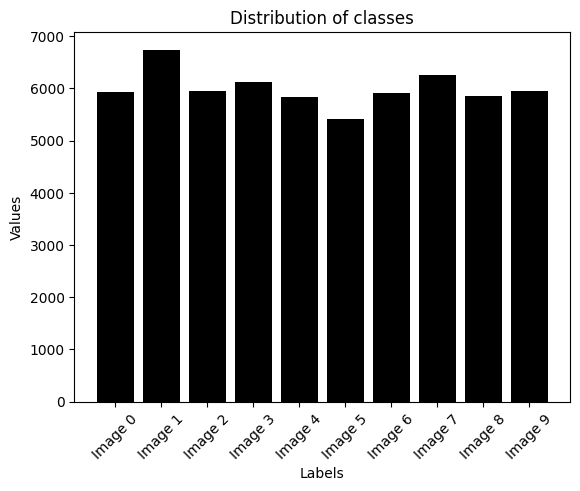

In [3]:
#data is a list which contains each individual class sorted at individual positions
#the shape of data is (10, num_of_samples) here 10 is different images of a single digit
data = [[] for _ in range(10)]
for i, j in trainset:
  data[j].append(i)

labels = ['Image 0', 'Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7', 'Image 8', 'Image 9']
values = [len(a) for a in data]
# Create bar graph
plt.bar(labels, values, color='black')
plt.title('Distribution of classes')
plt.xlabel('Labels')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

In [4]:
#utility functions

#updates counter
def counter_update(n):
  if (counter[n] == len(data[n]) - 1):
      counter[n] = 0
  else:
      counter[n] +=1

#creates a list of values
def list_cr(q):
  w = [0, 0, 0, 0]
  w[-1] = q%10
  q = q//10
  w[-2] = q%10
  q = q//10
  w[-3] = q%10
  q = q//10
  w[-4] = q%10
  return w

#plots the image
def pn(a):
  image_data = a

  # Plotting the image
  plt.imshow(image_data, cmap='gray')
  plt.colorbar()  # Shows the color scale
  plt.show()

#returns a list which contains the final prediction from logits
def number(tensor, t = 0.5):
  list = []
  x = 0
  for m in [10,20,30,40]:
    a = []
    for i, j in enumerate(tensor[x:m]):
      if j>=t:
        a.append(i)
    x = m
    list.append(a)
  return list

## Generating Four-Digit Images

Now we'll create new images that each represent a four-digit number. This involves concatenating four single-digit MNIST images side by side to form a single image tensor that the model can learn from.

Here's the process:
- We initialize a `counter` array to keep track of the digits used.
- For each number from 0 to `max_num` (10,000 in this case), we create `num_samples` (10 here) images.
- We concatenate the individual MNIST digit images for each digit in the number and add a new dimension to the tensor to prepare it for input into a CNN.

In [5]:
#4 digit image creation
counter = [0]*10

temp_tensors = []
max_num = 10000
num_samples = 10
labels = []
for i in range(max_num):
  l = list_cr(i)

  for j in range(num_samples):
    m0 = data[l[0]][counter[l[0]]][0]
    counter_update(l[0])
    m1 = data[l[1]][counter[l[1]]][0]
    counter_update(l[1])
    m2 = data[l[2]][counter[l[2]]][0]
    counter_update(l[2])
    m3 = data[l[3]][counter[l[3]]][0]
    counter_update(l[3])
    # Concatenate tensors and add to temporary list
    #unsqueezing it for CNN's
    temp_tensors.append(torch.cat((m0, m1, m2, m3), dim=1).unsqueeze(0))

    #labels
    x = [0.0] * 40
    pos = 0
    for k in l:
      x[k+pos] = 1
      pos+=10
    labels.append(x)

image_tensor = torch.stack(temp_tensors)
label_tensor = torch.tensor(labels)

# Checking the final shape of the tensor
print(image_tensor.shape)
print(label_tensor.shape)

torch.Size([100000, 1, 28, 112])
torch.Size([100000, 40])


##3 sample outputs of the dataset and their respective labels


Image of:  2229  Sample number:  5


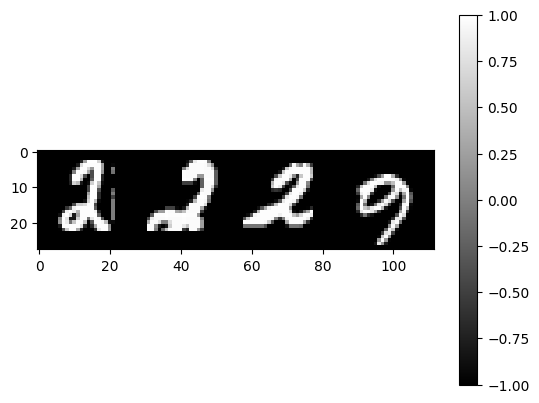

Image of:  984  Sample number:  1


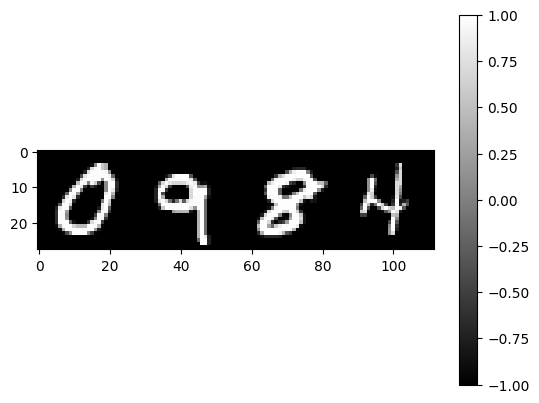

Image of:  5702  Sample number:  4


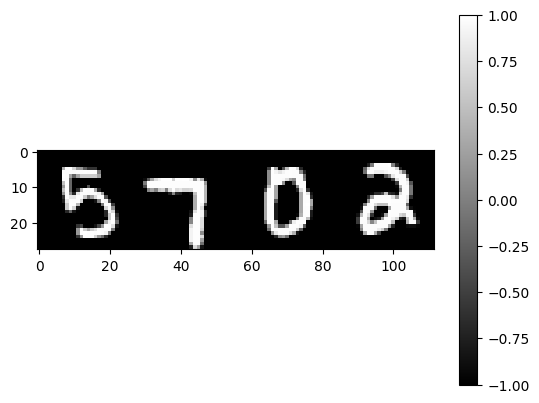

In [6]:
random_indices = random.sample(range(len(image_tensor)), 3)
random_values = [image_tensor[i] for i in random_indices]
sample_images = list(zip(random_values, random_indices))

for i, j in sample_images:
  print('Image of: ',j//10, ' Sample number: ', j%10 + 1)
  plt.imshow(i[0], cmap='gray')
  plt.colorbar()  # Shows the color scale
  plt.show()

## Dataset Setup and Model Definition

We've packaged our four-digit images into a dataset, splitting it into 80% for training and 20% for testing. This ensures our model learns from a variety of examples and is tested on unseen data. For iterating over this data, we use `DataLoader`s for both training and testing sets.

Our model, a Convolutional Neural Network (CNN), features two convolutional and max pooling layers, followed by three fully connected layers. This setup is designed to process our images and predict the sequence of digits accurately.

## Loss Function

To train our model, we use a custom loss function that handles the unique structure of our problem—predicting four digits at once. It calculates the error for each digit's prediction and averages them, giving us a measure of how well the model is performing across all four digits.


In [7]:
# Define the dataset
dataset = TensorDataset(image_tensor, label_tensor)
#shape of image_tensor torch.Size([100000, 1, 28, 112])
#shape of label_tensor torch.Size([100000, 10])

# Splitting the dataset into training and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2) # Output: 32 x 28 x 112
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 32 x 14 x 56
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) # Output: 64 x 14 x 56
        # Max pooling layer
        # After second pooling: 64 x 7 x 28
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 28, 1024)  # Adapt this to the output of the last pool
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 40)  # Assuming 10 classes as in your initial setup

    def forward(self, x):
        # Apply convolutions, followed by max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 7 * 28)  # Reshape input to batch_size x (64*7*28)
        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # The last layer will return logits.
        x = self.fc3(x)

        return x


def custom_loss(outputs, labels):
    loss_fn = torch.nn.CrossEntropyLoss()

    batch_size = outputs.shape[0]
    loss = 0.0
    for i in range(4):  # Loop over the four 10-unit blocks
        output_block = outputs[:, i*10:(i+1)*10]
        label_block = labels[:, i*10:(i+1)*10]

        _, label_indices = torch.max(label_block, 1)
        block_loss = loss_fn(output_block, label_indices)

        # Compute the cross-entropy loss for the block
        #block_loss = loss_fn(output_block, label_block)
        loss += block_loss

    # Average the loss over the four blocks
    loss /= 4.0
    return loss


## Training and Evaluation Overview

We trained our model for 7 epochs, using the Adam optimizer and a GPU when available for speed. Training involved learning from data and updating weights, while evaluation checked the model's performance on unseen test data.

### Key Steps:
- **Training**: Set model to learn mode, calculate loss, update weights.
- **Evaluation**: Switch to evaluate mode, compute test loss to check for generalization.

Post-training, we plotted the losses to assess learning progress and identify potential overfitting or underfitting, simplifying the understanding of the model's performance over the epochs.

Epoch 1, Train Loss: 0.22867574032098054, Test Loss: 0.0705334006990202
Epoch 2, Train Loss: 0.05490076473355293, Test Loss: 0.0514474760996886
Epoch 3, Train Loss: 0.03530666484888643, Test Loss: 0.0491323231900938
Epoch 4, Train Loss: 0.02612292063999921, Test Loss: 0.05024394678463713
Epoch 5, Train Loss: 0.02089969879174605, Test Loss: 0.057230702203403885
Epoch 6, Train Loss: 0.018076427715539467, Test Loss: 0.0522867080788262
Epoch 7, Train Loss: 0.016142228582536337, Test Loss: 0.05555681135511389
Training complete


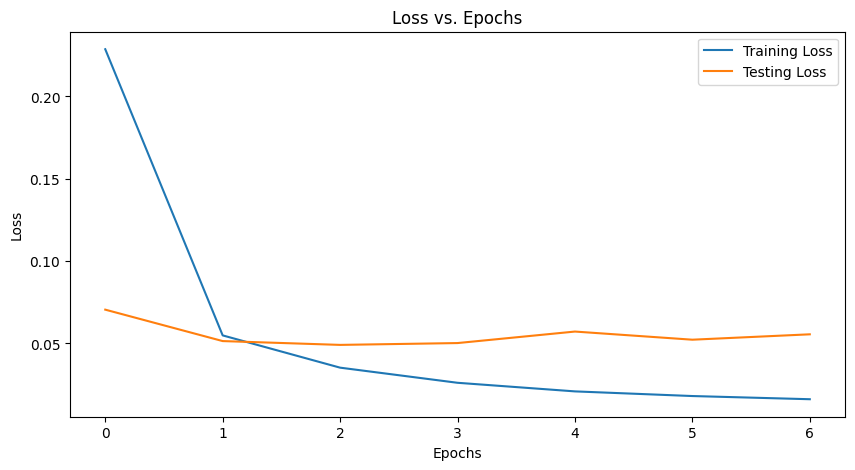

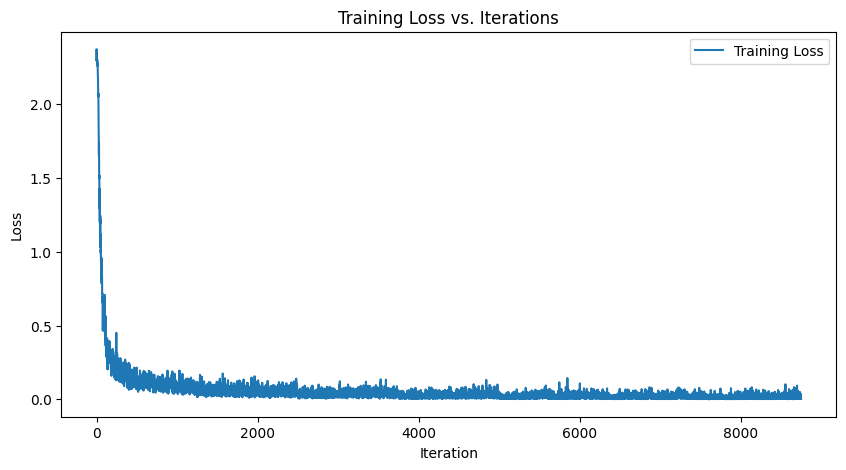

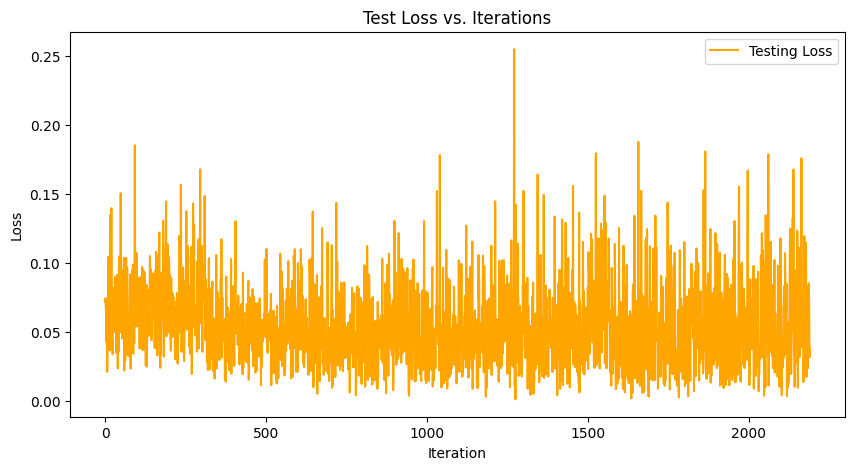

In [8]:
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the chosen device
model.to(device)
# Training loop
num_epochs = 7
train_losses = []
test_losses = []

loss_sample = []
loss_sample_test = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = custom_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_sample.append(loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation on the test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = custom_loss(outputs, labels)
            test_loss += loss.item()
            loss_sample_test.append(loss.item())
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')
print("Training complete")

# Plotting the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss_sample, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss vs. Iterations')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss_sample_test, label='Testing Loss', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Test Loss vs. Iterations')
plt.legend()
plt.show()

## Model Performance Metrics

After the final evaluation, we analyzed key performance metrics to understand our model's effectiveness:

- **Test Accuracy**: Shows the proportion of correct predictions out of all test set predictions.
- **Precision and Recall**: Precision indicates the accuracy of positive predictions, while recall quantifies the model's ability to find all relevant instances.
- **F1 Score**: Combines precision and recall into a single metric by taking their harmonic mean, useful for comparing models with similar accuracies but different distributions of precision and recall.
- **Hamming Loss**: Measures the fraction of labels that are incorrectly predicted, reflecting the error rate across all classifications.

These metrics collectively give us a detailed picture of the model's strengths and weaknesses, guiding further optimization.


In [9]:
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score

# Convert logits outputs to binary predictions
def logits_to_binary(outputs):
  a = []
  for i in outputs:
    b = [0] * 40
    for j in range(4):
      output_block = i[j*10 : (j+1)*10]
      output_block_softmax = F.softmax(output_block, dim=0)
      index = torch.argmax(output_block_softmax).item()
      b[j*10 + index] = 1
    a.append(b)
  return torch.tensor(a)

# Evaluation on the test set for accuracy and Hamming loss
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = logits_to_binary(outputs)  # Convert logits to binary predictions
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate accuracy and Hamming loss
acc_score = accuracy_score(all_labels, all_preds)
hamm_loss = hamming_loss(all_labels, all_preds)

print(f'Test Accuracy: {acc_score}')
print(f'Hamming Loss: {hamm_loss}')
print('Precision:', precision_score(all_labels, all_preds, average='macro'))
print('Recall:', recall_score(all_labels, all_preds, average='macro'))
print('F1-score:', f1_score(all_labels, all_preds, average='macro'))


Test Accuracy: 0.94555
Hamming Loss: 0.0028025
Precision: 0.9860950600125833
Recall: 0.9859711918785804
F1-score: 0.9859787458171188
